# Fake News Detection Using LSTM

This colab notebook serves as an implementation of using machine learning as a way to detect fake news





**1. Loading Google Drive to get the data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2. Data Preparation and Merging**

In [ ]:
import pandas as pd

# Load both sets
fake_news = pd.read_csv('/content/drive/MyDrive/News _dataset/Fake.csv')
real_news = pd.read_csv('/content/drive/MyDrive/News _dataset/True.csv')

# 1 is label for fake news, while 0 is label for real news
fake_news['label'] = 1
real_news['label'] = 0

# Combine the datasets
data = pd.concat([fake_news, real_news], ignore_index=True)

#Shuffle the data and randomly take 600 rows
data = data.sample(n=1000).reset_index(drop=True)

data = data.dropna(subset=['text'])

# Check the combined dataset
print(data.head())
print(data.tail())

                                               title  \
0  FORBES LIST OF “The World’s Most Powerful Peop...   
1  EU looks for 'big pot of money' to handle migr...   
2  CNN TRIES TO Push FAKE Story About Size Of New...   
3  After British PM May's speech fiasco, her part...   
4  SHOCKER! BRATTY KID WHO SAID “Screw Our Presid...   

                                                text    subject  \
0  Hey Michelle Guess what? For the first time in...   politics   
1  BRUSSELS (Reuters) - European Union leaders wi...  worldnews   
2  Here s CNN s tweet with pictures comparing Oba...   politics   
3  LONDON (Reuters) - It was meant to be the spee...  worldnews   
4  Immediately after this happened, Charles Kraut...  left-news   

                date  label  
0       Dec 17, 2016      1  
1  October 18, 2017       0  
2       Apr 19, 2017      1  
3   October 5, 2017       0  
4       Jan 20, 2017      1  
                                                 title  \
995  Brazil election c

**3. Checking Labels**

In [ ]:
label_counts = data['label'].value_counts()
print(label_counts)

label
1    529
0    471
Name: count, dtype: int64


**4. Cleaning Text + remove stop words**

In [ ]:
# Import necessary libraries for text cleaning
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Define the cleaning function
def clean_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stop words
    return text

# Apply cleaning to text
data['clean_text'] = data['text'].fillna('').apply(clean_text)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**5. Train Test Split and Tokenizing and Padding Data**

In [ ]:
from sklearn.model_selection import train_test_split
# Split data into training and testing sets
X = data['clean_text']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Import the tokenizer and pad_sequences functions from Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the text data
MAX_WORDS = 10000  # Maximum number of words in the vocabulary
MAX_SEQ_LEN = 300  # Maximum length of input sequences
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences and pad them to ensure equal length
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQ_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQ_LEN)

**6. Training Word2Vec and Populating the Embedding Matrix**

In [ ]:
# Import gensim for Word2Vec model training
from gensim.models import Word2Vec

# Tokenize sentences into lists of words
sentences = [text.split() for text in X_train]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.train(sentences, total_examples=len(sentences), epochs=10)

import numpy as np

# Create an embedding matrix for the words in the tokenizer's vocabulary
EMBEDDING_DIM = 100  # Must match the Word2Vec vector size
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    if i < MAX_WORDS:
        try:
            embedding_vector = word2vec_model.wv[word]
            embedding_matrix[i] = embedding_vector
        except KeyError:
            embedding_matrix[i] = np.zeros(EMBEDDING_DIM)

**7. Creating a Sequential model architecture**

In [ ]:
# Import necessary layers from Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

# Build the LSTM model
model = Sequential()

model.add(Embedding(input_dim=embedding_matrix.shape[0],  # Match input_dim to embedding matrix size
                    output_dim=EMBEDDING_DIM,
                    input_length=MAX_SEQ_LEN,
                    weights=[embedding_matrix],
                    trainable=False))  # Set to False to not modify the Word2Vec weights

# 2. Bidirectional LSTM layer
model.add(Bidirectional(LSTM(128, return_sequences=False)))

# 3. Dropout layer to prevent overfitting
model.add(Dropout(0.5))

# 4. Dense output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       2,011,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,011,600 (7.67 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,011,600 (7.67 MB)

**8. Training the model**

In [ ]:
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_data=(X_test_pad, y_test))

**9. Model Evaluation & Testing**

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test Accuracy: {test_accuracy}')

# Generate predictions
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.8941 - loss: 0.4090
Test Accuracy: 0.8949999809265137
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 401ms/step


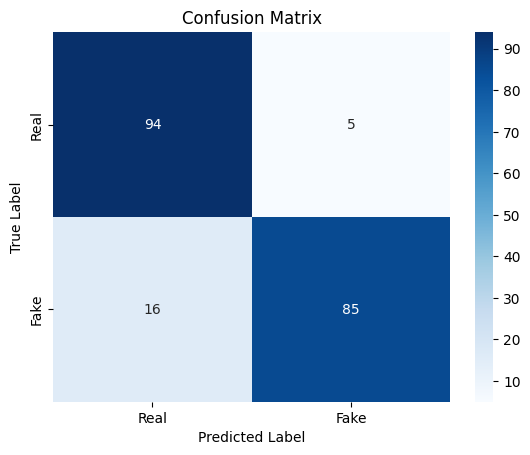

In [ ]:
# Import necessary libraries for plotting
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Display classification report
print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))

              precision    recall  f1-score   support

        Real       0.85      0.95      0.90        99
        Fake       0.94      0.84      0.89       101

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.89       200
weighted avg       0.90      0.90      0.89       200



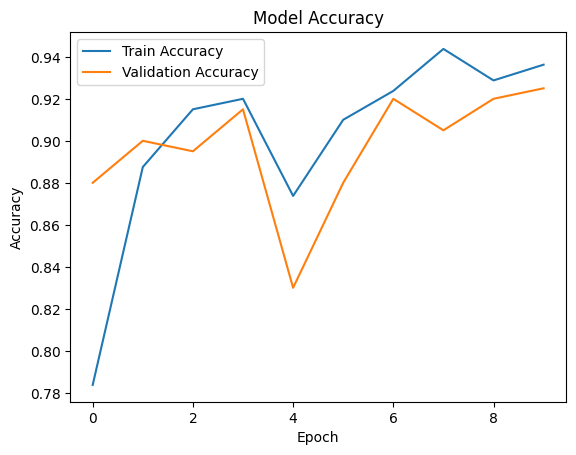

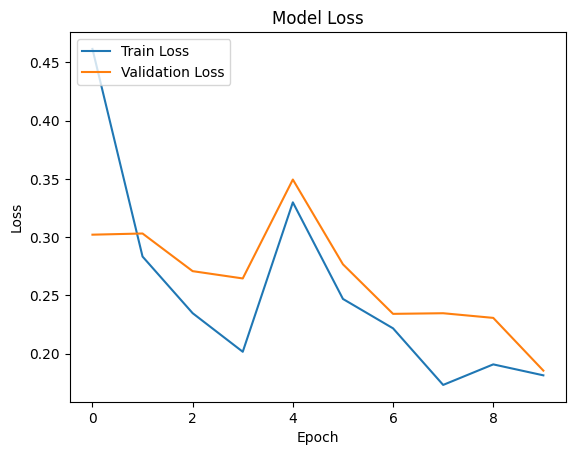

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

**9. Saving the model**

In [ ]:
model.save('fake_news_detection_model.keras')

**Same model as the one in the report**

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/drive/MyDrive/fake_news_detection_model.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


**Test it on something**

In [ ]:
def prepare_text_for_prediction(text):
    # Step 1: Clean the input text
    cleaned_text = clean_text(text)

    # Step 2: Tokenize the text (convert words to numbers)
    text_sequence = tokenizer.texts_to_sequences([cleaned_text])

    # Step 3: Pad the sequence to the same length used in training
    text_padded = pad_sequences(text_sequence, maxlen=MAX_SEQ_LEN)

    return text_padded

In [ ]:
def predict_fake_or_real(text):
    # Prepare the text
    text_padded = prepare_text_for_prediction(text)

    # Use the model to make a prediction
    prediction = model.predict(text_padded)

    # Interpret the prediction: if the prediction is > 0.5, it's fake news
    if prediction > 0.5:
        return "Fake News"
    else:
        return "Real News"


In [ ]:
news_text = "Obama Administration has killed millions of americans with the way their healthcare system is designed."
result = predict_fake_or_real(news_text)
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
Fake News
